## Importing required libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
import math
from sklearn.metrics import mean_squared_error
from nltk.corpus import stopwords

In [2]:
!pip install pmdarima --user

## TIME SERIES ANALYSIS

## Loading stock price dataset and performing Exploratory analysis

In [3]:
df_prices = pd.read_csv('C:/Users/jites/Desktop/historical_data.csv')
df_prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-06-30,7154.270020,7218.279785,7154.270020,7193.850098,7193.850098,28600.0
1,2005-07-01,7165.450195,7228.569824,7154.930176,7210.770020,7210.770020,12600.0
2,2005-07-04,7186.740234,7284.410156,7186.740234,7277.310059,7277.310059,9600.0
3,2005-07-05,7275.000000,7308.720215,7209.859863,7220.250000,7220.250000,12600.0
4,2005-07-06,7227.220215,7296.180176,7227.220215,7287.600098,7287.600098,13400.0


In [4]:
# Converting Date column to datetime column
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3700 entries, 0 to 3699
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3700 non-null   datetime64[ns]
 1   Open       3672 non-null   float64       
 2   High       3672 non-null   float64       
 3   Low        3672 non-null   float64       
 4   Close      3672 non-null   float64       
 5   Adj Close  3672 non-null   float64       
 6   Volume     3672 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 202.5 KB


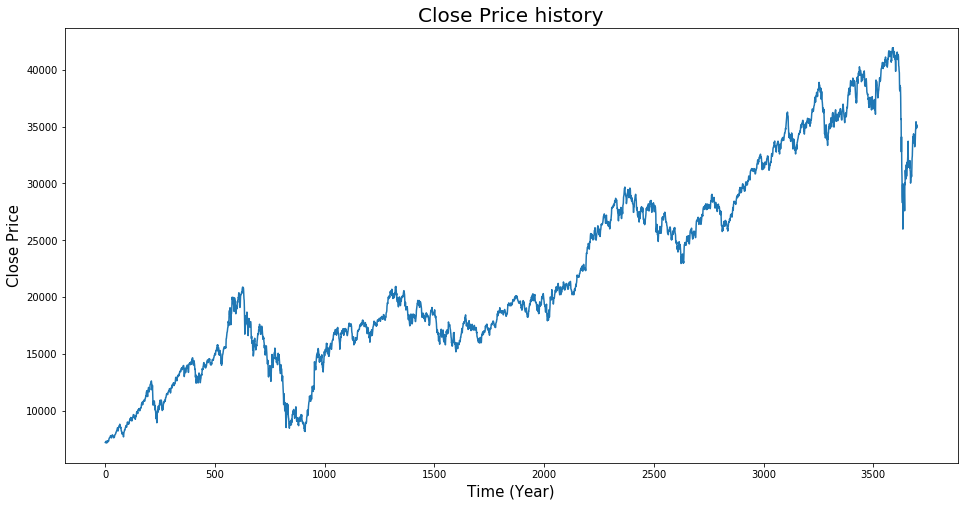

In [5]:
df_prices.dropna(inplace=True)
#plot
plt.figure(figsize=(16,8))
plt.plot(df_prices['Close'], label='Close Price history')
plt.title('Close Price history', fontsize=20)
plt.xlabel('Time (Year)', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.show()

## Plotting moving average

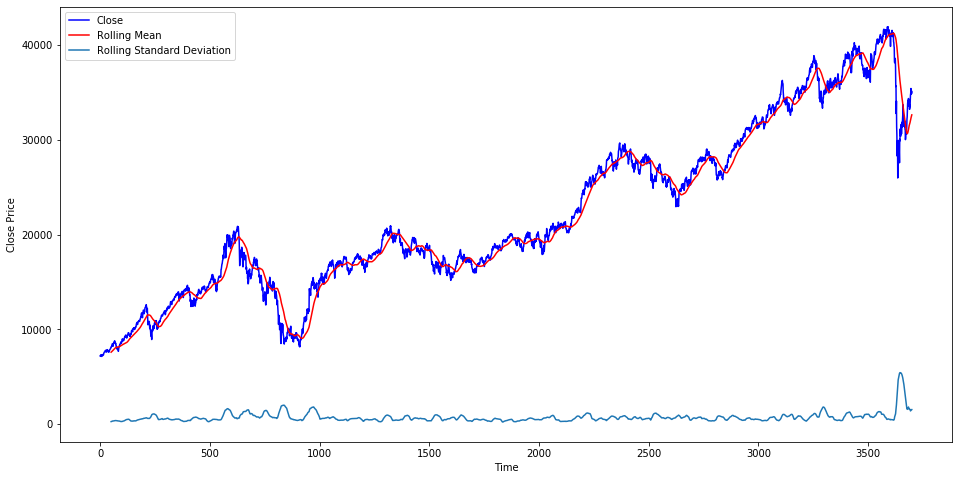

In [6]:
close = df_prices['Close']
ma = close.rolling(window=50).mean()
std = close.rolling(window=50).std()

plt.figure(figsize=(16,8))
df_prices['Close'].plot(color='b', label='Close')
ma.plot(color = 'r', label='Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.ylabel('Close Price')
plt.xlabel('Time')
plt.legend()
plt.show()

## Plotting returns

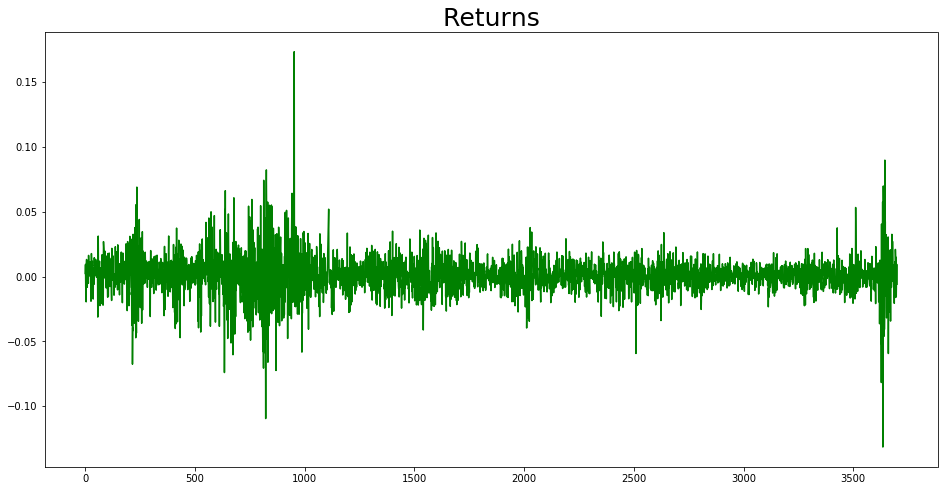

In [7]:
returns = close / close.shift(1) - 1

plt.figure(figsize=(16,8))
returns.plot(color='g', label='Return')
plt.title('Returns', fontsize=25)
plt.show()

## Dividing into training and test sets

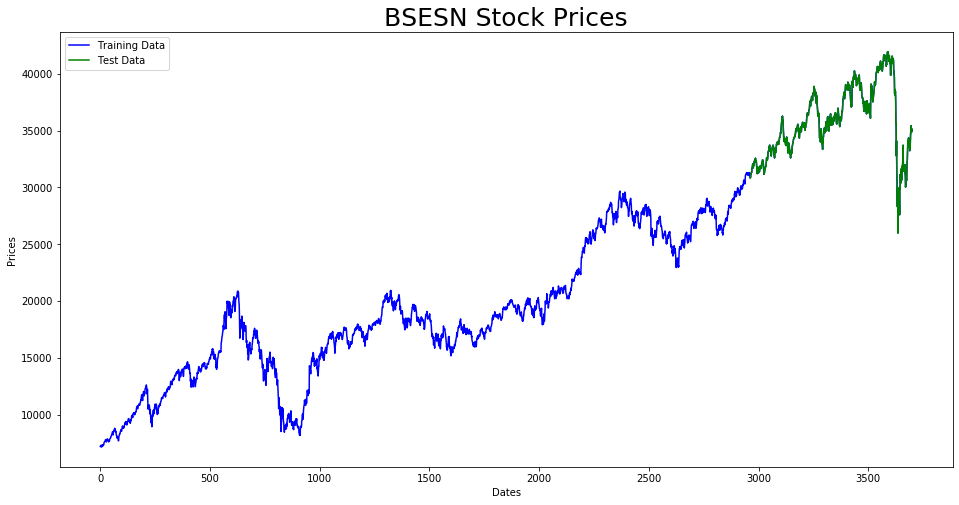

In [8]:
train_data, test_data = df_prices[0:int(len(df_prices)*0.8)], df_prices[int(len(df_prices)*0.8):]
plt.figure(figsize=(16,8))
plt.title('BSESN Stock Prices', fontsize=25)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_prices['Close'], 'blue', label='Training Data')
plt.plot(test_data['Close'], 'green', label='Test Data')
plt.legend()
plt.show()

## Creating an ARIMA model for Numerical Analysis

### ARIMA
ARIMA (AutoRegressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA models explain a time series based on its own past values, basically its own lags and the lagged forecast errors.

An ARIMA model is characterized by 3 terms (p, d, q):

 - p is the order of the AR term

 - d is the number of differencing required to make the time series stationary

 - q is the order of the MA term

As we see in the parameters required by the model, any stationary time series can be modeled with ARIMA models.

### Stationarity
A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times.

Subtract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times.

And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model.

### ADF test
We'll use the Augumented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_prices.Close.dropna())
print(f'ADF Staistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Staistic: -1.2818477507754722
p-value: 0.6374355348664578


p-value > 0.05, therefore time-series is not stationary.

In [10]:
from pmdarima.arima.utils import ndiffs
ndiffs(df_prices.Close, test='adf')

1

Therefore d value is 1.

**p**

p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors.
We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.
The partial autocorrelation represents the correlation between the series and its lags.

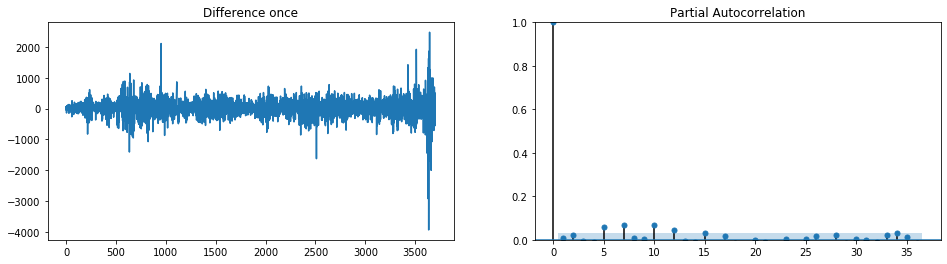

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff = df_prices.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0,1)
plot_pacf(diff, ax=ax2);

**q**

q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.
We can look at the ACF plot for the number of MA terms.

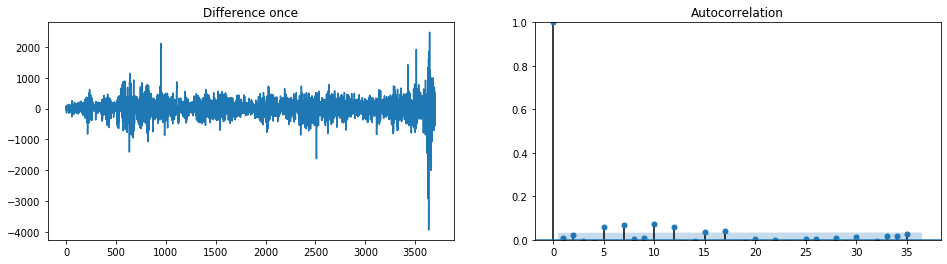

In [12]:
diff = df_prices.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

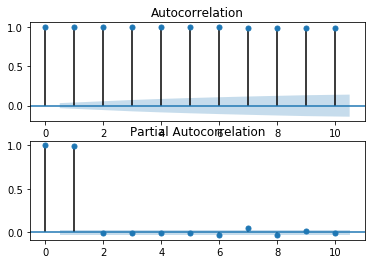

In [13]:
dataset = df_prices.copy()
dataset.set_index('Date', inplace=True)
dataset = dataset[['Close']]

plt.figure()
plt.subplot(211)
plot_acf(dataset, ax=plt.gca(), lags=10)
plt.subplot(212)
plot_pacf(dataset, ax=plt.gca(), lags=10)
plt.show()

## Deciding our ARIMA model
Our main job is to decide the order of the AR, I, MA parts which are donated by (p,d,q) respectively. So we use auto arima to figure out the order of the ARIMA model. 

In [14]:
from pmdarima import auto_arima
model = auto_arima(train_data['Close'], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=40423.084, Time=2.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40441.008, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40424.311, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40423.300, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40442.434, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=40425.364, Time=0.95 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=40421.619, Time=1.93 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=40424.354, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=40423.533, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=40423.455, Time=2.61 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=40424.767, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.68 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=40423.231, Time=0.52 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 13.895 seconds


## Rolling forecasts 
A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

In [15]:
train_ar = train_data['Close'].values
test_ar = test_data['Close'].values
history = [x for x in train_ar]

# generate a prediction for each element on the test set.
preds = list()
for t in range(len(test_ar)):
    mod = ARIMA(history, order = (2,1,1))
    mod_fit = mod.fit(disp=0)
    output = mod_fit.forecast()
    yhat = output[0]
    preds.append(yhat)
    obs = test_ar[t]
    history.append(obs)

# Evaluate forecasts
print('Mean: ', test_data['Close'].mean())

rmse = math.sqrt(mean_squared_error(test_ar, preds))
print('Test RMSE: %.3f' % rmse)

Mean:  35833.91908225161
Test RMSE: 438.135


The root mean squared should be very smaller than the mean value of test set. In this case, we can see the average error is gonna be roughly 438.135/35833.919 *100 = 1.22% of the actual value. So our ARIMA model is ready to go!

In [16]:
print(mod_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 3670
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -25980.570
Method:                       css-mle   S.D. of innovations            287.216
Date:                Tue, 28 Sep 2021   AIC                          51971.139
Time:                        16:39:30   BIC                          52002.179
Sample:                             1   HQIC                         51982.190
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6225      4.891      1.558      0.119      -1.964      17.209
ar.L1.D.y     -0.0720      0.384     -0.187      0.851      -0.825       0.681
ar.L2.D.y      0.0239      0.017      1.425      0.1

## Visualizing the predictions

<Figure size 1152x576 with 0 Axes>

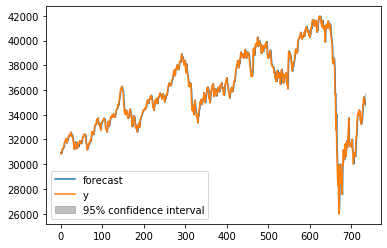

In [17]:
start = len(train_ar)
end = len(train_ar) + len(test_ar) - 1
plt.figure(figsize=(16,8))
mod_fit.plot_predict(start=start, end=end, dynamic=False)
plt.show()

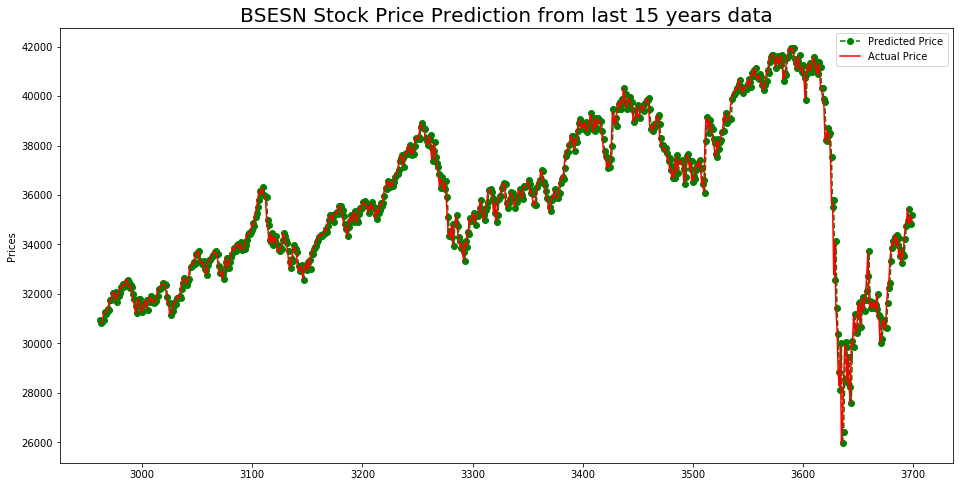

In [18]:
plt.figure(figsize=(16,8))
plt.plot(test_data.index, preds, color='g', marker='o', linestyle='dashed', label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='r', label='Actual Price')
plt.legend()
plt.title('BSESN Stock Price Prediction from last 15 years data', fontsize=20)
plt.ylabel('Prices')
plt.show()

The above image is a zoomed in version. From this can be noticed how the two curves closely follow each other. However, the predicted price seems to look like a “noisy” version of the actual price.

This analysis using ARIMA lead overall to appreciable results. This model demonstrated in fact to offer good prediction accuracy and to be relatively fast compared to other alternatives such as RNNs (Recurrent Neural Networks).

# TEXTUAL ANALYSIS

## Loading Textual (News Headlines) dataset and performing Exploratory Analysis

In [19]:
cols = ['Date', 'Category', 'News']
df_news = pd.read_csv('C:/Users/jites/Downloads/india-news-headlines.csv', names=cols)
df_news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3424063,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424066,20201231,removed,Govt extends deadline for use of FASTag till F...


In [20]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis=1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 78.4+ MB


In [21]:
# Converting data type of Date column
df_news['Date'] = pd.to_datetime(df_news['Date'], format='%Y%m%d')
df_news

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa
5,2001-01-02,Extra buses to clear tourist traffic
...,...,...
3424063,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,2020-12-31,Covid-19: Despite dip in cases; Rajasthan amon...
3424066,2020-12-31,Govt extends deadline for use of FASTag till F...


In [22]:
# Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x: ' '.join(x))
df_news = df_news.drop_duplicates()
df_news.reset_index(inplace=True, drop=True)
df_news

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Man recovers charred remains of 'thief' from h...
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [23]:
df_news['News']

0       Status quo will not be disturbed at Ayodhya; s...
1       Powerless north India gropes in the dark Think...
2       The string that pulled Stephen Hawking to Indi...
3       Light combat craft takes India into club class...
4       Light combat craft takes India into club class...
                              ...                        
7257    #BigInterview! Dhritiman Chatterjee: Nobody da...
7258    Horoscope Today; 28 December 2020: Check astro...
7259    Man recovers charred remains of 'thief' from h...
7260    Numerology Readings 30 December 2020: Predicti...
7261    Horoscope Today; 31 December 2020: Check astro...
Name: News, Length: 7262, dtype: object

## Adding Subjectivity and Polarity scores 

In [24]:
from textblob import TextBlob

In [25]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [26]:
# Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(get_subjectivity)
df_news['Polarity'] = df_news['News'].apply(get_polarity)
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333
1,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961
3,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...,0.395808,0.035886
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...,0.412945,0.070517
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.424021,0.061210
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...,0.441660,0.043496


## Visualizing Subjectivity and Polarity scores

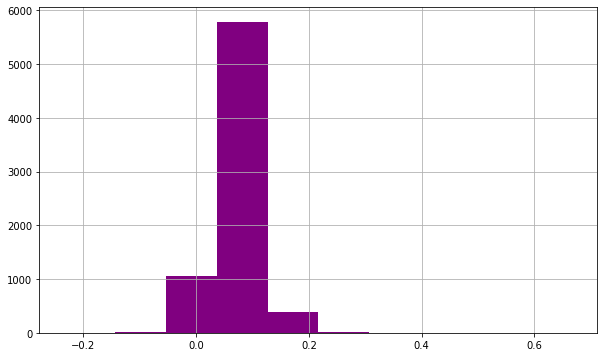

In [27]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

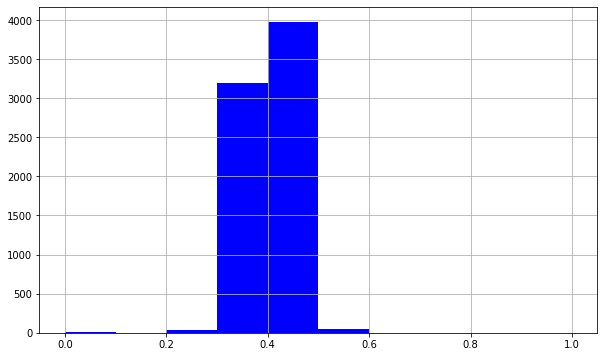

In [28]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

## Performing Sentiment Analysis over the news headlines

In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [30]:
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333,-0.9811,0.122,0.807,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
3,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024,0.9633,0.124,0.722,0.154
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.4215,0.152,0.704,0.143
...,...,...,...,...,...,...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...,0.395808,0.035886,-0.9997,0.126,0.798,0.076
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...,0.412945,0.070517,-0.9998,0.137,0.771,0.092
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.424021,0.061210,-0.9999,0.148,0.758,0.094
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...,0.441660,0.043496,-0.9999,0.141,0.780,0.079


## Creating a hybrid model from Numerical and Textual data

In [31]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2005-06-30,7154.270020,7218.279785,7154.270020,7193.850098,7193.850098,28600.0,US kids hit fat camps in big way Experts add m...,0.392252,0.155306,-0.9210,0.118,0.777,0.105
1,2005-07-01,7165.450195,7228.569824,7154.930176,7210.770020,7210.770020,12600.0,Kuch Meetha Ho Jaye Bachke Rehna Re Baba Silsi...,0.441401,0.120223,0.9846,0.076,0.785,0.138
2,2005-07-04,7186.740234,7284.410156,7186.740234,7277.310059,7277.310059,9600.0,Boogeyman Bush in judge test Gladiators strike...,0.369919,-0.022525,-0.9907,0.153,0.797,0.050
3,2005-07-05,7275.000000,7308.720215,7209.859863,7220.250000,7220.250000,12600.0,It was great fun: Pierce A sport called hedoni...,0.349948,0.141555,0.8210,0.134,0.713,0.154
4,2005-07-06,7227.220215,7296.180176,7227.220215,7287.600098,7287.600098,13400.0,Heroes of Dec 13 prove mettle again Govt corne...,0.463967,0.095579,0.9306,0.135,0.715,0.150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,2020-06-23,35015.730469,35482.160156,34843.691406,35430.429688,35430.429688,25200.0,Delayed periods? Time to accept that household...,0.370002,0.067428,-0.9999,0.156,0.761,0.083
3668,2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,34868.980469,26600.0,I never thought I had a voice until today: Vid...,0.387802,0.088329,-0.9999,0.135,0.789,0.076
3669,2020-06-25,34525.390625,35081.609375,34499.781250,34842.101563,34842.101563,24600.0,Truck firms look for new export markets to sel...,0.401736,0.023232,-0.9999,0.138,0.800,0.062
3670,2020-06-26,35144.781250,35254.878906,34910.339844,35171.269531,35171.269531,24800.0,Containment zone residents slam high prices ch...,0.381841,0.068333,-0.9999,0.162,0.749,0.089


In [32]:
df = df_merge[['Close', 'Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,7193.850098,0.392252,0.155306,-0.9210,0.118,0.777,0.105
1,7210.770020,0.441401,0.120223,0.9846,0.076,0.785,0.138
2,7277.310059,0.369919,-0.022525,-0.9907,0.153,0.797,0.050
3,7220.250000,0.349948,0.141555,0.8210,0.134,0.713,0.154
4,7287.600098,0.463967,0.095579,0.9306,0.135,0.715,0.150
...,...,...,...,...,...,...,...
3667,35430.429688,0.370002,0.067428,-0.9999,0.156,0.761,0.083
3668,34868.980469,0.387802,0.088329,-0.9999,0.135,0.789,0.076
3669,34842.101563,0.401736,0.023232,-0.9999,0.138,0.800,0.062
3670,35171.269531,0.381841,0.068333,-0.9999,0.162,0.749,0.089


## Training and Testing different models for Stock Price/Performance Analysis

In [33]:
# Normalizing the dataset
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.001400,0.424831,0.588415,0.03950,0.248619,0.680412,0.315217
1,0.001886,0.588627,0.493791,0.99230,0.016575,0.707904,0.494565
2,0.003797,0.350402,0.108774,0.00465,0.441989,0.749141,0.016304
3,0.002158,0.283844,0.551326,0.91050,0.337017,0.460481,0.581522
4,0.004093,0.663830,0.427321,0.96530,0.342541,0.467354,0.559783


In [34]:
X = new_df.drop('Close', axis=1)
y = new_df['Close']

In [35]:
X.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.424831,0.588415,0.03950,0.248619,0.680412,0.315217
1,0.588627,0.493791,0.99230,0.016575,0.707904,0.494565
2,0.350402,0.108774,0.00465,0.441989,0.749141,0.016304
3,0.283844,0.551326,0.91050,0.337017,0.460481,0.581522
4,0.663830,0.427321,0.96530,0.342541,0.467354,0.559783


In [36]:
# Splitting the dataset into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape

(2937, 6)

In [37]:
X_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
1948,0.431692,0.378563,0.00005,0.574586,0.422680,0.396739
2148,0.351232,0.355140,0.00005,0.403315,0.618557,0.255435
217,0.637176,0.382309,0.00085,0.502762,0.618557,0.163043
670,0.457321,0.379453,0.00015,0.635359,0.481100,0.250000
1242,0.416281,0.391581,0.00005,0.491713,0.601375,0.201087
977,0.532866,0.320181,0.00005,0.535912,0.532646,0.266304
1070,0.487694,0.309287,0.00030,0.259669,0.766323,0.168478
3523,0.435827,0.311410,0.00005,0.436464,0.642612,0.190217
3000,0.475016,0.413409,0.00030,0.287293,0.673540,0.293478
2564,0.453584,0.336021,0.00010,0.469613,0.484536,0.402174


### Random Forest model

In [38]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(math.sqrt(mean_squared_error(rf_pred, y_test)), 'RMSE')

0.17212683200230333 RMSE


### Decision Tree model

In [39]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr_pred = dtr.predict(X_test)
print(math.sqrt(mean_squared_error(dtr_pred, y_test)), 'RMSE')

0.22975449127044695 RMSE


### AdaBoost model

In [40]:
from sklearn.ensemble import AdaBoostRegressor
adb = AdaBoostRegressor()
adb.fit(X_train, y_train)
adb_pred = adb.predict(X_test)
print(math.sqrt(mean_squared_error(adb_pred, y_test)), 'RMSE')

0.1940997141791356 RMSE


### XGBoost model

In [41]:
import xgboost
xgb = xgboost.XGBRegressor()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
print(math.sqrt(mean_squared_error(xgb_pred, y_test)), 'RMSE')

0.18233673479672566 RMSE


## Conclusion
I have used four models to carry out hybrid analysis. The root mean squared error of each model is:
 - Random Forest Model: 0.17212683200230333
 - Decision Tree Model: 0.22975449127044695
 - AdaBoost Model: 0.1940997141791356
 - XGBoost Model: 0.18233673479672566

From the RMSE values we can see that **Random Forest Regressor model** gives a more accurate output as compared to other models.